In [1]:
import pandas as pd
import torch
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.ops import box_iou
from torch.utils.data import DataLoader
from rich.console import Console
from utils.datasets import WheatDataset
import numpy as np

%load_ext rich
from rich.progress import Progress
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [2]:
train_df = pd.read_csv('data/competition_train.csv')
train_df = train_df.loc[~train_df["BoxesString"].str.contains("no_box"),:].reindex()
train_df["BoxesString"] = train_df["BoxesString"].apply(lambda x: x.split(";")).apply(lambda x: [[int(num) for num in i.split(" ")] for i in x if i != "no_box"])
test_df = pd.read_csv('data/competition_test.csv')
test_df = test_df.loc[~test_df["BoxesString"].str.contains("no_box"),:].reindex()
test_df["BoxesString"] = test_df["BoxesString"].apply(lambda x: x.split(";")).apply(lambda x: [[int(num) for num in i.split(" ")] for i in x if i != "no_box"])
val_df = pd.read_csv('data/competition_val.csv')
val_df = val_df.loc[~val_df["BoxesString"].str.contains("no_box"),:].reindex()
val_df["BoxesString"] = val_df["BoxesString"].apply(lambda x: x.split(";")).apply(lambda x: [[int(num) for num in i.split(" ")] for i in x if i != "no_box"])

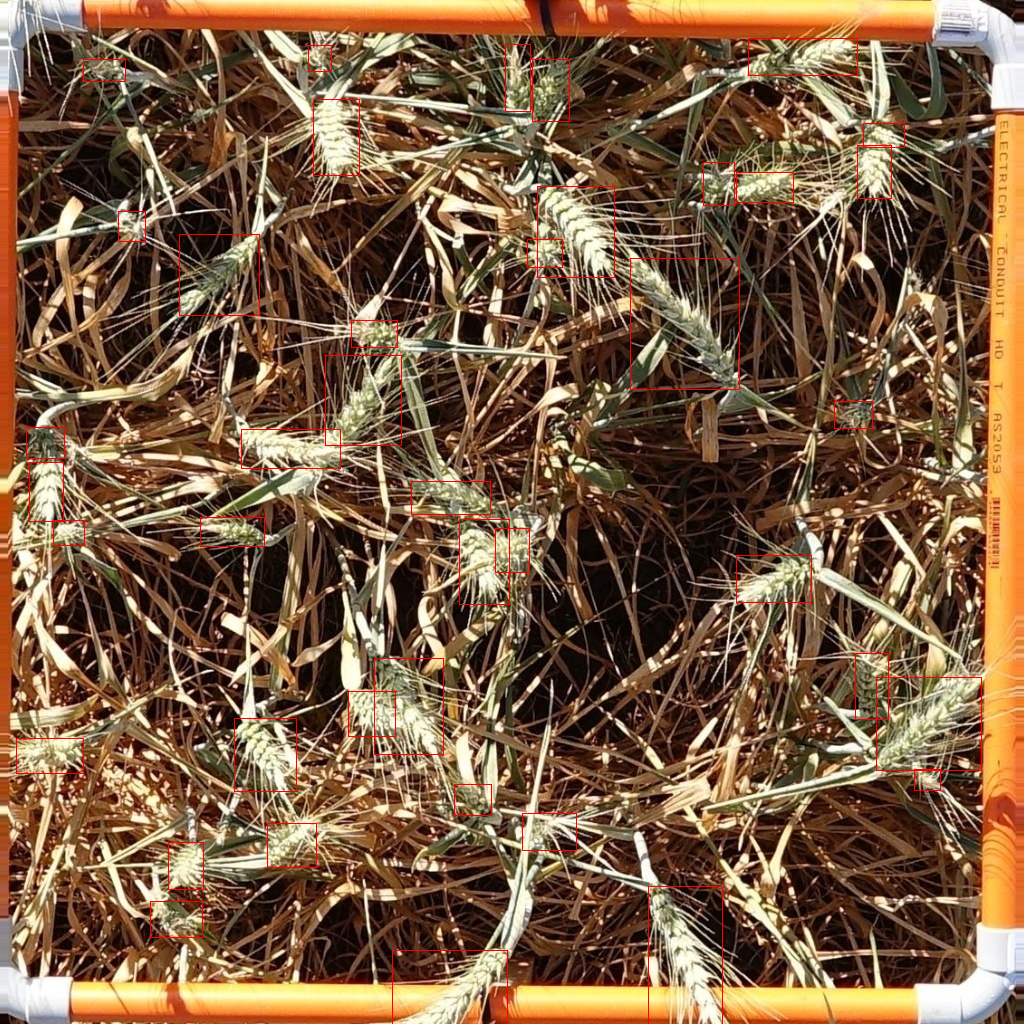

In [3]:
train_dataset = WheatDataset(train_df, "data/images")
test_dataset = WheatDataset(test_df, "data/images")
val_dataset = WheatDataset(val_df, "data/images")

test_dataset.show_image(3)

In [4]:
largest = 0
for i in (train_dataset.df["BoxesString"]):
    if len(i) > largest:
        largest = len(i)
print("Max detections per image in train?: ", largest)
largest_test = 0
for i in (test_dataset.df["BoxesString"]):
    if len(i) > largest_test:
        largest_test = len(i)
print("Max detections per image in test?: ", largest_test)
print("Minimun detections required for training: ",max(largest,largest_test))
model = fasterrcnn_resnet50_fpn(progress=True, num_classes=2,pretrained_backbone=True,box_detections_per_img=200)  
model.to(device)

Max detections per image in train?:  129
Max detections per image in test?:  190
Minimun detections required for training:  190


c:\Users\jbote\Desktop\crag\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
c:\Users\jbote\Desktop\crag\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights_backbone=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights_backbone=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (rel

In [5]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
print(get_n_params(model))

41299161


In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True,collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True,collate_fn=collate_fn)

In [7]:

epoch_losses = {"loss_classifier": [], "loss_box_reg": [], "loss_objectness": [], "loss_rpn_box_reg": [], "total_loss": []}
metrics = {
    "average_iou_tp": [],
    "precision": [],
    "recall": [],
    "total_true_positives": [],
    "total_predictions": [],
    "total_targets": []
}

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

console=Console(force_terminal=False)
with Progress(console=console) as progress:
    epoch_task = progress.add_task("[blue]Epochs:", total=10)
    for epoch in range(10):
        ###
        # Training Loop
        ###
        batch_progress = progress.add_task("[red]Batch:", total=len(train_loader))
        model.train()
        losses_storage = {"loss_classifier": [], "loss_box_reg": [], "loss_objectness": [], "loss_rpn_box_reg": [], "total_loss": []}
        for batch in train_loader:
            
            images, targets, image_ids = batch
            images = torch.stack(images).to(device)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            losses = model(images, targets)
            total_loss = sum(loss for loss in losses.values())
            total_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            for key, value in losses.items():
                losses_storage[key].append(value.item())
                losses_storage["total_loss"].append(total_loss.item())
            progress.update(batch_progress, advance=1,description="""Batch losses:
                            classifier:{x1:.3f}
                            box_reg: {x2:.3f}
                            objectness: {x3:.3f}
                            rpn_box_reg: {x4:.3f}
                            total_loss: {x5:.3f}""".format(x1=losses_storage['loss_classifier'][-1],
                                                           x2=losses_storage['loss_box_reg'][-1],
                                                           x3=losses_storage['loss_objectness'][-1],
                                                           x4=losses_storage['loss_rpn_box_reg'][-1],
                                                           x5=losses_storage['total_loss'][-1]))


        for key, value in epoch_losses.items():
            epoch_losses[key].append(np.mean(losses_storage[key]))
        console.log(f"Epoch {epoch + 1} Losses: {epoch_losses}")
        progress.advance(epoch_task)
        progress.remove_task(batch_progress)
        ###
        # Test Loop
        ###
        model.eval()
        batch_progress = progress.add_task("[green]Validation batch:", total=len(test_loader))
        
        for batch in test_loader:
            images, targets, image_ids = batch
            images = torch.stack(images).to(device)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            with torch.no_grad():
                outputs = model(images)
            
            # Initialize batch-wise metrics
            batch_true_positives_iou = 0
            batch_true_positives = 0
            batch_predictions = 0
            batch_targets = 0
            
            for output, target in zip(outputs, targets):
                if output["boxes"].shape[0] == 0 or target["boxes"].shape[0] == 0:
                    continue  # Skip if no detections or no ground truths
                
                ious = box_iou(output["boxes"], target["boxes"])
                max_ious, max_indices = ious.max(dim=1)
                true_positives_mask = max_ious >= 0.5  # IoU threshold
                true_positives_iou = max_ious[true_positives_mask]
                
                batch_true_positives_iou += true_positives_iou.sum().item()
                batch_true_positives += true_positives_mask.sum().item()
                batch_predictions += output["boxes"].shape[0]
                batch_targets += target["boxes"].shape[0]
            
            progress.update(batch_progress, advance=1)
        
        progress.remove_task(batch_progress)
        
        # Calculate and store metrics
        average_iou_tp = batch_true_positives_iou / batch_true_positives if batch_true_positives > 0 else 0
        precision = batch_true_positives / batch_predictions if batch_predictions > 0 else 0
        recall = batch_true_positives / batch_targets if batch_targets > 0 else 0
        
        metrics["average_iou_tp"].append(average_iou_tp)
        metrics["precision"].append(precision)
        metrics["recall"].append(recall)
        metrics["total_true_positives"].append(batch_true_positives)
        metrics["total_predictions"].append(batch_predictions)
        metrics["total_targets"].append(batch_targets)

    # Print summary for the epoch
    console.log(f"Summary for this epoch:")
    console.log(f"Average IoU for True Positives: {average_iou_tp:.4f}")
    console.log(f"Precision: {precision:.4f}")
    console.log(f"Recall: {recall:.4f}")
    console.log(f"Total True Positives: {batch_true_positives}")
    console.log(f"Total Predictions: {batch_predictions}")
    console.log(f"Total Ground Truth Boxes: {batch_targets}")




Output()

In [8]:
torch.save(model.state_dict(), "model.pth")
import pickle
with open('training_losses.pkl', 'wb') as fp:
    pickle.dump(epoch_losses, fp)

In [11]:
images, targets, image_ids = next(iter(val_loader))

In [6]:
model.load_state_dict(torch.load("model.pth"))
model.eval()
iou_threshold = 0.5  # Define the IoU threshold for true positives
total_true_positives_iou = 0  # To accumulate IoU of true positives
total_true_positives = 0  # To count the number of true positives
total_predictions = 0  # To count the total number of predictions
total_targets = 0  # To count the total number of targets

for batch in val_loader:
    images, targets,batch_id= batch
    images = torch.stack(images).to(device)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    with torch.no_grad():
        outputs = model(images)
    
    # Calculate IoU and determine true positives
    
    
    for output, target in zip(outputs, targets):
        score = output["scores"] > 0.5
        output["boxes"] = output["boxes"][score]
        output["labels"] = output["labels"][score]
        if output["boxes"].shape[0] == 0 or target["boxes"].shape[0] == 0:
            continue  # Skip if no boxes are detected or no ground truths
        ious = box_iou(output["boxes"], target["boxes"])
        # Find the maximum IoU for each prediction
        max_ious, max_indices = ious.max(dim=1)
        # Consider detections with IoU > threshold as true positives
        true_positives_mask = max_ious >= iou_threshold
        true_positives_iou = max_ious[true_positives_mask]
        
        # Update totals
        total_true_positives_iou += true_positives_iou.sum().item()
        total_true_positives += true_positives_mask.sum().item()
        total_predictions += output["boxes"].shape[0]
        total_targets += target["boxes"].shape[0]

# Calculate metrics
average_iou_tp = total_true_positives_iou / total_true_positives if total_true_positives > 0 else 0
precision = total_true_positives / total_predictions if total_predictions > 0 else 0
recall = total_true_positives / total_targets if total_targets > 0 else 0

# Print summary
print(f"Summary for this epoch:")
print(f"Average IoU for True Positives: {average_iou_tp:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Total True Positives: {total_true_positives}")
print(f"Total Predictions: {total_predictions}")
print(f"Total Ground Truth Boxes: {total_targets}")

Summary for this epoch:
Average IoU for True Positives: 0.7330
Precision: 0.8731
Recall: 0.7623
Total True Positives: 33721
Total Predictions: 38622
Total Ground Truth Boxes: 44233


In [ ]:
iou.flatten().sort(descending=True).values[:100]

tensor(0.1912, device='cuda:0')

In [ ]:
box_iou(target["boxes"][0], output["boxes"][0])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 box_iou(target["boxes"][0], output["boxes"][0])                                              │
│   2                                                                                              │
│                                                                                                  │
│ c:\Users\fede_\.conda\envs\detection\Lib\site-packages\torchvision\ops\boxes.py:271 in box_iou   │
│                                                                                                  │
│   268 │   """                                                                                    │
│   269 │   if not torch.jit.is_scripting() and not torch.jit.is_tracing():                        │
│   270 │   │   _log_api_usage_once(box_iou)                                                       │
│ ❱ 271 │   inter, union = _box_inter_union(boxes1, boxes2)                                        │
│   272 │   iou = inter / union                                                                    │
│   273 │   return iou                                                                             │
│   274                                                                                            │
│                                                                                                  │
│ c:\Users\fede_\.conda\envs\detection\Lib\site-packages\torchvision\ops\boxes.py:241 in           │
│ _box_inter_union                                                                                 │
│                                                                                                  │
│   238 # implementation from https://github.com/kuangliu/torchcv/blob/master/torchcv/utils/box.   │
│   239 # with slight modifications                                                                │
│   240 def _box_inter_union(boxes1: Tensor, boxes2: Tensor) -> Tuple[Tensor, Tensor]:             │
│ ❱ 241 │   area1 = box_area(boxes1)                                                               │
│   242 │   area2 = box_area(boxes2)                                                               │
│   243 │                                                                                          │
│   244 │   lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]                          │
│                                                                                                  │
│ c:\Users\fede_\.conda\envs\detection\Lib\site-packages\torchvision\ops\boxes.py:235 in box_area  │
│                                                                                                  │
│   232 │   if not torch.jit.is_scripting() and not torch.jit.is_tracing():                        │
│   233 │   │   _log_api_usage_once(box_area)                                                      │
│   234 │   boxes = _upcast(boxes)                                                                 │
│ ❱ 235 │   return (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])                       │
│   236                                                                                            │
│   237                                                                                            │
│   238 # implementation from https://github.com/kuangliu/torchcv/blob/master/torchcv/utils/box.   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: too many indices for tensor of dimension 1

In [ ]:
target["boxes"][0],output["boxes"][0]


(
    tensor([385., 150., 422., 254.], device='cuda:0'),
    tensor([699.2657, 158.2131, 761.2765, 189.3031], device='cuda:0')
)

In [ ]:
for batch in test_loader:
    with torch.no_grad():
        losses_storage = {"loss_classifier": [], "loss_box_reg": [], "loss_objectness": [], "loss_rpn_box_reg": [], "total_loss": []}
        batch = next(iter(train_loader))
        images, targets, image_ids = batch
        images = torch.stack(images).to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        losses = model(images, targets)
        total_loss = sum(loss for loss in losses.values())

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:9                                                                                    │
│                                                                                                  │
│    6 │   │   images = torch.stack(images).to(device)                                             │
│    7 │   │   targets = [{k: v.to(device) for k, v in t.items()} for t in targets]                │
│    8 │   │   losses = model(images, targets)                                                     │
│ ❱  9 │   │   total_loss = sum(loss for loss in losses.values())                                  │
│   10                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'list' object has no attribute 'values'

In [ ]:
losses


[
    {
        'boxes': tensor([[1.2076e+02, 8.0649e+02, 2.0696e+02, 8.8023e+02],
        [8.0624e+01, 8.0776e+02, 1.6782e+02, 8.8507e+02],
        [2.8409e+02, 7.4576e+02, 3.6779e+02, 8.1744e+02],
        [3.1858e+02, 7.9868e+02, 3.7479e+02, 8.2723e+02],
        [1.3125e+02, 8.3339e+02, 2.1824e+02, 9.0815e+02],
        [4.5532e+02, 4.3953e+02, 9.1703e+02, 6.7423e+02],
        [3.6685e+02, 7.1846e+01, 8.5630e+02, 2.9774e+02],
        [1.2350e+02, 7.8162e+02, 2.0479e+02, 8.5299e+02],
        [5.5983e+02, 3.7653e+02, 6.4451e+02, 4.4770e+02],
        [6.5684e+02, 4.0906e+02, 9.9539e+02, 7.3269e+02],
        [7.5951e+01, 7.6316e+02, 1.5524e+02, 8.3470e+02],
        [5.6043e+02, 4.5973e+02, 6.4176e+02, 5.3138e+02],
        [3.7846e+01, 8.1057e+02, 1.1873e+02, 8.8635e+02],
        [3.3331e+02, 7.7554e+02, 4.1717e+02, 8.5136e+02],
        [5.4090e+02, 3.5301e+01, 8.7425e+02, 3.6567e+02],
        [1.3348e+02, 8.6133e+02, 1.7379e+02, 9.0606e+02],
        [8.1629e+00, 6.0868e+02, 4.7904e+02, 8